In [3]:
import descarteslabs as dl
import descarteslabs.workflows as wf

import matplotlib.pyplot as plt

## Proxy Objects

The boring fundamentals you should know

In [4]:
one = wf.Int(1)  # this is a lazy proxy object.
two = one + 1

# 1 + 1 hasn't been computed yet:
# `two` holds a dependency graph representing the operation `1 + 1`
two

In [5]:
two.compute()  # send that graph to the backend, execute it, wait for the result

[               ] | Steps: 0/0 | Stage: STAGE_DONE | Status: STATUS_SUCCESS

2

In [6]:
# use `block=False` to submit a computation asynchronously, returning a Job object
job = two.compute(block=False)

In [7]:
job.refresh()  # reload the job's status
job.done       # is it done?

False

In [8]:
job.result()  # wait for and load the result

[               ] | Steps: 0/0 | Stage: STAGE_DONE | Status: STATUS_SUCCESS

2

## Image Basics

In [9]:
img = wf.Image.from_id("13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat:sinu-cat")
# An Image is a proxy object holding multiple (ordered) bands of raster data,
# plus some metadata.

# Images don't have a set spatial extent, CRS, resolution, etc:
# that's determined at computation time by the GeoContext you pass in (keep reading!)

In [10]:
img.geometry

In [11]:
img.properties

<descarteslabs.workflows.types.containers.known_dict.KnownDict[{'date': Datetime, 'crs': Str, 'product': Str, 'geotrans': Tuple[Float, Float, Float, Float, Float, Float], 'id': Str}, Str, Any] at 0x11feaf310>

In [12]:
# Workflows knows in advance what some properties will be, and can return the right type of object.
# Here, 'date' is always a Datetime.
img.properties['date']

In [13]:
# Unknown properties are returned as a `wf.Any` object.
# `Any` supports any operation, but if the property doesn't exist,
# or you try to do something invalid with it, that'll cause an error at compute time.
img.properties['foobar']

In [14]:
img.bandinfo

<descarteslabs.workflows.types.containers.dict_.Dict[Str, KnownDict[{'data_range': Tuple[Float, Float], 'id': Str, 'unit': Str, 'name': Str}, Str, Any]] at 0x11feaf210>

In [15]:
rgb = img.pick_bands('red green blue')
# Image with just the RGB bands (in that order)
# previously, `img` contained every band defined for that image.

In [16]:
# computing an Image (or other geospatial object) requires a GeoContext.

# Workflows has its own GeoContext proxy type, but you can also use
# GeoContext objects (including `DLTile`s) from `dl.scenes` interchangeably.

# get the default GeoContext for this image from Scenes
_, ctx = dl.scenes.Scene.from_id("13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat:sinu-cat")

rgb_result = rgb.compute(ctx)

[###############] | Steps: 17/17 | Stage: STAGE_DONE | Status: STATUS_SUCCESS

In [17]:
# .compute returns a simple container type to hold the NumPy array and metadata dictionaries
# from the result.

# this `workflows.containers.containers.Image` object is *different* from the
# `Image` objects we've been working with above; it's just a simple class
# for holding results
rgb_result

In [18]:
type(rgb_result.bands), rgb_result.bands.shape

(numpy.ma.core.MaskedArray, (3, 500, 500))

In [19]:
rgb_result.properties

{u'acquired': u'2018-11-02T03:18:46.349000+00:00',
 u'bucket': u'storage-13ee3865fe538f2baf9c51f7316c57d25bece097-products',
 u'crs': u'+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ',
 u'date': u'2018-11-02T03:18:46.349000+00:00',
 u'descartes_version': u'dl-platform-ingest',
 u'directory': u'13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat/',
 u'file_md5s': (u'28d86678cda34bc1b235009b4f3f8e09',),
 u'file_sizes': (1001598,),
 u'files': (u'28d86678cda34bc1b235009b4f3f8e09.tif',),
 u'geometry': {u'coordinates': (((-79.10810710223798, 62.952441458184595),
    (19.777026775559495, 62.952441458184595),
    (9.455287969178897, 17.986411845195597),
    (-37.82115187671559, 17.986411845195597),
    (-79.10810710223798, 62.952441458184595)),),
  u'type': u'Polygon'},
 u'geotrans': (-4000000.0, 10000.0, 0.0, 7000000.0, 0.0, -10000.0),
 u'id': u'13ee3865fe538f2baf9c51f7316c57d25bece097:sinu-cat:sinu-cat',
 u'identifier': u'13ee3865fe538f2baf9c51f7316c57d25bec

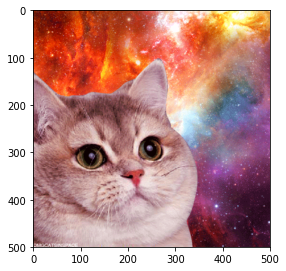

In [20]:
# our first real(?) data back from Workflows!
dl.scenes.display(rgb_result.bands, size=4)

In [21]:
# note that you can call `.compute` on pretty much any proxy object, not just the Image.
# If we pull out just the `geotrans` of the Image, our computation won't even touch any raster data.
# (see how there were 0 steps to do)

rgb.properties['geotrans'].compute(ctx)

[               ] | Steps: 0/0 | Stage: STAGE_DONE | Status: STATUS_SUCCESS

(-4000000.0, 10000.0, 0.0, 7000000.0, 0.0, -10000.0)

In [22]:
# let's calculate some band math

red, blue = img.unpack_bands('red blue')
# same as:
# red = img.pick_bands('red')
# blue = img.pick_bands('blue')
# (but less typing)

In [23]:
# Like NumPy arrays, Image objects support vectorized operators like +, -, etc.
# The broadcasting rules are the similar:

FAIL = img.pick_bands('red green') * img.pick_bands('red green blue')
# the bands don't match between the two Images

OK = img.pick_bands('green') * img.pick_bands('red green blue')
# a 1-band Image is broadcast to all bands in the other Image.
# this would multiply `red`, `green`, and `blue` by the `green` band and return a 3-band Image

OK = img.pick_bands('green') * img.pick_bands('blue')
# if *both* Images have 1 band, it's ok if their names don't match

OK = img.pick_bands('red green blue') * img.pick_bands('blue red green')
# bands are matched up by name, not positionally.
# this would multiply red by red, blue by blue, and green by green
# (even though they're in different orders)

In [24]:
radness = (blue - red) / (blue + red)
# calculate Normalized Difference Radness Index

# IMPORTANT: values in Workflows images are always floats, in *physical rage* if defined, or the range 0-1.

In [25]:
# view an Image on a map with `Image.visualize`.
# the image is computed on-the-fly by the backend as you zoom and pan around
radness.visualize(name="NDRI", location=[45, -20], zoom_start=4, scales=[[-1, 0.3]])

# note that we didn't give a GeoContext here:
# the GeoContext is defined by where you're looking on the map

# if nothing shows up, log in at http://iam.descarteslabs.com and refresh the page

In [26]:
# we can `.compute()` our derived Image too,
# to get back data as a NumPy array
radness_ = radness.compute(ctx)

[###############] | Steps: 5/5 | Stage: STAGE_DONE | Status: STATUS_SUCCESS

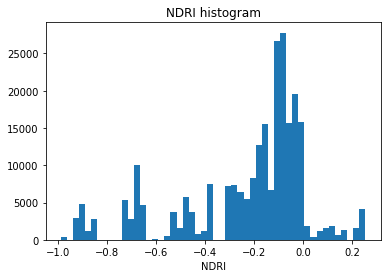

In [27]:
plt.hist(radness_.bands.compressed().flat, bins=50)  # .compressed() removes any masked-out values
plt.title("NDRI histogram")
plt.xlabel("NDRI")
plt.show()

In [28]:
# mask out parts of the RGB Image where `radness` is low
only_radness = rgb.mask(radness < -0.5)

## ImageCollection basics

In [29]:
landsat_8 = wf.ImageCollection.from_id("landsat:LC08:01:T1:TOAR")
# an ImageCollection is like a cross between a 4D NumPy array and a list of Images.

# this ImageCollection (theoretically) contains every Image in Landsat 8.
# But when a GeoContex is supplied at computation time (either by a map, or passing one into .compute),
# the metadata lookup and computation will just happen within that area of interest.

In [30]:
green, swir1 = landsat_8.unpack_bands('green swir1')
# same interface as Image
# but here, `green` and `swir1` are ImageCollections of the green/swir1 band from every image in Landsat 8

In [31]:
ndsi = (green - swir1) / (green + swir1)
# ImageCollections also support vectorized operators
# This calculates NDSI over every image in Landsat 8

In [32]:
winter = ndsi.filter(lambda img: (img.properties['date'].month >= 11) | (img.properties['date'].month <= 5))
# .filter takes a function, runs it on every Image in the ImageCollection, and only keeps Images where the function returns True

# you can write this function in normal Python syntax, with a couple caveats:
#
# - no conditionals or control flow (if statements, for loops)
#
# - python `and` and `or` statements don't work for comparing booleans;
#   instead, use the bitwise `&` and `|` operators (like above).
#   be sure to wrap your statements in parenthesis like above:
#   the bitwise operators have higher precedence than `and` and `or`!
#
#   `(x > 1) & (y == 2)` : correct
#   `x > 1 & y == 2`     : not what you expected; equivalent to `x > (1 & y) == 2`

In [33]:
winter_mean = winter.mean()
# .mean makes a mean composite of all Images, returing one Image.
# other compositors include `min`, `max`, `sum`, `std`, `median`, and `count`

In [63]:
winter_mean.visualize(name="Winter mean NDSI", location=[29, 83], zoom_start=9, scales=[[-0.5, 1]])
# winter mean NDSI composite over all of landsat 8 T1
# (this may take a while to load)

In [129]:
s1 = wf.ImageCollection.from_id("sentinel-1:GRD", start_datetime="2018-01-01", end_datetime="2018-08-01")
# you can give `start_datetime` and `end_datetime` for coarse date bounding, which is efficient than `filter`.
# of course, you can combine `start_datetime` and `filter` if you want

In [130]:
s1_img = s1.pick_bands("vv vh").median()
# right now, we can only display Images on a map, not ImageCollections.
# so we make a median composite of Sentinel-1 just for fun

In [141]:
low_snow = s1_img.mask(winter_mean > 0.3)
# you can mask one Image or ImageCollection with another Image or ImageCollection that contains boolean values.
# like with NumPy, `True` means masked/invalid.

# also notice that we're interoperating between two different sensor products here:
# masking a sentinel-1 SAR composite with snow cover computed from landsat-8! neat!

In [142]:
vv_vh_vv = low_snow.concat(low_snow.pick_bands('vv_median'))

In [143]:
vv_vh_vv.visualize(name="low_snow", location=[29, 83], zoom_start=9, scales=[[0, 0.6], [0, 0.6], [0, 0.6]])

In [140]:
# try adjusing the masking threshold a few cells above and re-running the map.

# data should load quite a bit faster the second time around,
# because all the intermediate results are cached automatically.
# (namely, computing NDSI and making composites of Landsat 8 and Sentinel-1) 

## It's not just about the pixels

In [39]:
nir, red = landsat_8.unpack_bands('nir red')

In [40]:
ndvi = (nir - red) / (nir + red)

In [41]:
ndsi = ndsi.rename_bands('ndsi')
ndvi = ndvi.rename_bands('ndvi')
# the band name for NDVI was originally `nir_sub_red_div_nir_add_red`---continuing
# to call it `red` or `nir` would be inaccurate, so Workflows automatically
# changes the name---but we rename it to something more meaningful.

# `rename_bands` can take new names positionally (what we did here), or by keyword arguments
# (we could have done `renane_bands(nir_sub_red_div_nir_add_red="ndvi")`, but that's awkward to write)

In [42]:
ndvi_ndsi_col = ndvi.concat_bands(ndsi)
# `concat_bands` appends the bands from another Image or ImageCollection.

#  note that this returns a *new* ImageCollection; it doesn't modify the original.
#  in general, all values in Workflows are immutable, and operations return copies.
#  (this isn't as inefficient as it sounds, because the underlying raster data isn't always copied.)

In [49]:
# define a function we'll map over every Image in the ImageCollection

def index_stats(img):
    date = img.properties['date']
    stats = img.meanpixels()
    # stats is a Dict[Str, Float], where keys are band names and values are the statistic (mean pixel value for that band).
    # that's why we renamed the bands, so the keys are nicer :)
    
    # note: `meanpixels` (and other such reducers) modify band names, so the `ndvi` band becomes `ndvi_mean`
    return (date, stats['ndvi_mean'], stats['ndsi_mean'])

In [50]:
l8_stats = ndvi_ndsi_col.map(index_stats)
# ImageCollection.map applies the function to every Image.

# if the mapper function returned an Image, we'd still get an ImageCollection back.
# however, our `index_stats` function just returns a tuple of a date and some numbers,
# so we get back a`workflows.List` proxy object.

In [51]:
type(l8_stats)

descarteslabs.workflows.types.containers.list_.List[Tuple[Datetime, Float, Float]]

In [52]:
# Notice that this is a `List[Tuple[Datetime, Float, Float]]`.
# That's not something you'd normally see in Python.

# The Workflows client is more strongly-typed than normal Python, and maintains its own type system.
# For example, values in `List`s all have to be the same type (in this case `Tuple[Datetime, Float, Float]`),
# and all the keys in a `Dict` are one type, and values are another type (as we saw above, with `Dict[Str, Float]`).

# This strictness helps prevent silly errors, and also lets it infer what type your results will be before you even execute them.

In [53]:
himalaya_tile = dl.scenes.DLTile.from_latlon(35, 76, 60, 512, 0)

In [55]:
l8_stats_ = l8_stats.compute(himalaya_tile)

[###############] | Steps: 1952/1952 | Stage: STAGE_DONE | Status: STATUS_SUCCESS

In [56]:
l8_stats_[:5]
# look, we actually did get back a list of tuples of a date and two floats

[(u'2016-01-12T05:29:41.742998+00:00',
  0.018266330507218417,
  0.5031715320676207),
 (u'2016-01-28T05:29:41.336400+00:00', 0.0140398823888516, 0.5351976492943566),
 (u'2016-02-13T05:29:34.609452+00:00',
  0.025325696248472977,
  0.43473396881425297),
 (u'2016-02-29T05:29:30.846120+00:00',
  0.015405631261259213,
  0.4693200603094098),
 (u'2016-03-16T05:29:26.559706+00:00',
  0.03459658795977355,
  0.3951994492390837)]

In [57]:
import pandas as pd

In [58]:
# stick it into pandas for further analysis.
# notice we didn't have to bring any raster data back to our client.

df = pd.DataFrame.from_records(l8_stats_, index='date', columns=['date', 'ndvi', 'ndsi'])
df.index = pd.to_datetime(df.index)
df

,ndvi,ndsi
date,,
2016-01-12 05:29:41.742998+00:00,0.018266,0.503172
2016-01-28 05:29:41.336400+00:00,0.014040,0.535198
2016-02-13 05:29:34.609452+00:00,0.025326,0.434734
2016-02-29 05:29:30.846120+00:00,0.015406,0.469320
2016-03-16 05:29:26.559706+00:00,0.034597,0.395199
2016-04-01 05:29:16.239779+00:00,0.008707,0.471589
2016-04-17 05:29:11.485655+00:00,0.021150,0.385194
2016-12-13 05:29:54.143919+00:00,0.023724,0.329141
2016-12-29 05:29:51.108161+00:00,0.033990,0.284324


/Users/gabejoseph/.local/share/virtualenvs/workflows-examples-ZimnatIE/lib/python2.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


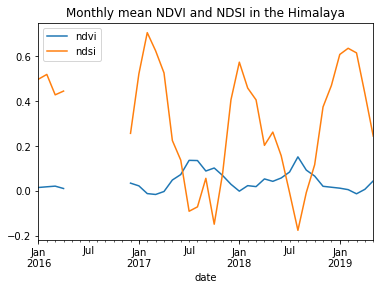

In [59]:
(
    df
    .resample("1m")
    .mean()
    .plot(title="Monthly mean NDVI and NDSI in the Himalaya")
)